<a href="https://colab.research.google.com/github/ibowan/Finite-Element-Modeling/blob/main/2025_Extended_Methods_for_Finite_Element_Modeling_ibrahim_malli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Simulation for Mesh: 5x5 elements...
Running Simulation for Mesh: 10x10 elements...
Running Simulation for Mesh: 25x25 elements...


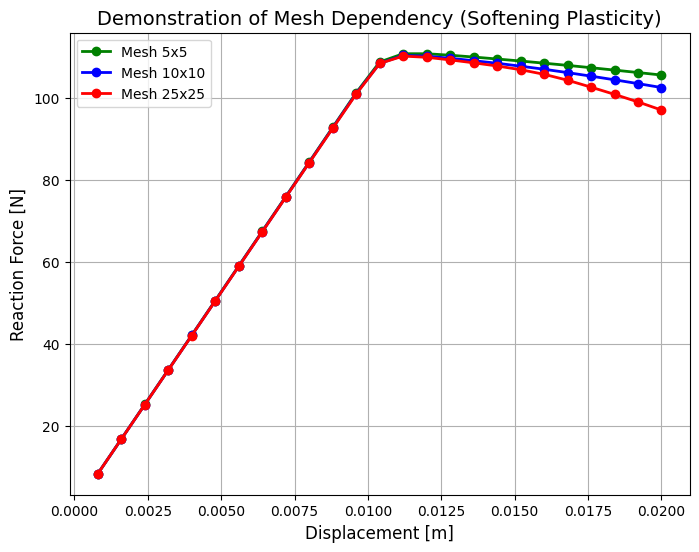

Interpretation: Note that the post-peak slope becomes steeper as the mesh is refined.
This indicates that energy dissipation is dependent on the element size (Mesh Dependency).


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# ==========================================
# 1. FEM CLASSES AND FUNCTIONS
# ==========================================

class Material:
    def __init__(self, E, nu, yield_stress, H):
        self.E = E
        self.nu = nu
        self.sy = yield_stress  # Initial Yield Stress
        self.H = H              # Hardening Modulus (Negative for softening)

        # Lame parameters (Plane Strain)
        self.mu = E / (2 * (1 + nu))
        self.lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))

        # Elastic Stiffness Matrix (Plane Strain)
        self.C = np.array([
            [self.lam + 2*self.mu, self.lam, 0],
            [self.lam, self.lam + 2*self.mu, 0],
            [0, 0, self.mu]
        ])

    def radial_return(self, strain_total, plastic_strain_old, alpha_old, is_weak):
        """
        Computes stress and consistent tangent using Radial Return algorithm
        for J2 Plasticity with Isotropic Softening.
        """
        # 1. Trial State (Elastic Predictor)
        strain_elastic_trial = strain_total - plastic_strain_old

        # Plane strain: epsilon_z = 0, but stress_z exists.
        # We work with vector [eps_xx, eps_yy, gamma_xy]
        sigma_trial = self.C @ strain_elastic_trial

        # Deviatoric stress calculation
        s_trial = np.zeros(3)
        p_trial = (sigma_trial[0] + sigma_trial[1]) / 3.0 # Approximate hydrostatic (2D)
        # Note: True trace needs sigma_z. For J2 2D implementation, we simplify deviator computation:
        # s_xx = 2G * e_dev_xx, etc.
        # Easier approach: Use standard formula s = sigma - tr(sigma)/3 I
        # For Plane Strain, sigma_zz = nu * (sigma_xx + sigma_yy).
        sigma_zz_trial = self.nu * (sigma_trial[0] + sigma_trial[1])
        hydro_pressure = (sigma_trial[0] + sigma_trial[1] + sigma_zz_trial) / 3.0

        s_xx = sigma_trial[0] - hydro_pressure
        s_yy = sigma_trial[1] - hydro_pressure
        s_zz = sigma_zz_trial - hydro_pressure
        s_xy = sigma_trial[2] # Shear stress

        # Von Mises equivalent stress (trial)
        # J2 = 0.5 * (s_xx^2 + s_yy^2 + s_zz^2) + s_xy^2
        J2 = 0.5 * (s_xx**2 + s_yy**2 + s_zz**2 + 2*s_xy**2) # factor 2 on shear for tensor notation vs Voigt
        # Actually in Voigt [sig_xx, sig_yy, tau_xy], J2 = 0.5*(s_x^2 + s_y^2 + s_z^2) + tau_xy^2
        q_trial = np.sqrt(3 * J2)

        # Current yield stress (Softening if H < 0)
        # Weak element has 5% lower yield stress to trigger localization
        sy_current = (self.sy * 0.95 if is_weak else self.sy) + self.H * alpha_old

        # Yield Function
        f = q_trial - sy_current

        if f <= 1e-6:
            # Elastic Step
            return sigma_trial, self.C, plastic_strain_old, alpha_old
        else:
            # Plastic Step (Return Mapping)
            # Consistency parameter delta_gamma
            # q_trial - 3*mu*d_gam - (sy + H*(alpha + d_gam)) = 0
            d_gam = f / (3 * self.mu + self.H)

            # Update variables
            q_new = sy_current + self.H * d_gam
            alpha_new = alpha_old + d_gam

            # Normal direction
            n = np.array([s_xx, s_yy, s_xy]) / q_trial

            # Correct Stress: sigma_new = sigma_trial - 2*mu*d_gam * n
            # Note: n is deviatoric tensor direction.
            # In Voigt: [n_xx, n_yy, n_xy]. Careful with shear factor in Voigt.
            # Standard radial return reduction:
            factor = (1.0 - (3 * self.mu * d_gam) / q_trial)
            s_new_xx = s_xx * factor
            s_new_yy = s_yy * factor
            s_new_xy = s_xy * factor
            # Hydrostatic pressure remains unchanged in J2 plasticity
            sigma_new_xx = s_new_xx + hydro_pressure
            sigma_new_yy = s_new_yy + hydro_pressure
            sigma_new_xy = s_new_xy

            sigma_new = np.array([sigma_new_xx, sigma_new_yy, sigma_new_xy])

            # Update Plastic Strain (Volume constant)
            # d_eps_p = d_gam * n_tensor.
            # Voigt: [d_eps_p_xx, d_eps_p_yy, 2*d_eps_p_xy]
            # n vector was [s_xx, s_yy, s_xy]/q.
            # plastic strain update:
            # eps_p_new = eps_p_old + d_gam * 3/2 * s_new / q_new ... strictly:
            # Flow vector P = dF/dSigma. For J2, P = 3/2 * s / q.
            # d_eps_p = d_gam * P.

            P = np.zeros(3)
            P[0] = 1.5 * s_new_xx / q_new
            P[1] = 1.5 * s_new_yy / q_new
            P[2] = 1.5 * s_new_xy / q_new * 2.0 # Engineering shear strain

            plastic_strain_new = plastic_strain_old + d_gam * P

            # Consistent Tangent Modulus (Algorithmic)
            # C_alg = K_bulk * 1 x 1 + 2*mu*beta * (I_dev - n x n) - 2*mu*gamma* n x n
            # Simplified approach for 1D code demo: Use elastic stiffness (loss of quadratic convergence but stable)
            # OR compute approximate tangent.
            # To ensure the demo works robustly without complex tensor algebra libraries:
            # We will use the Elastic Tangent (C) for the global stiffness matrix.
            # This is "Modified Newton-Raphson". It converges slower but is easier to code.
            # For strict quadratic convergence, we need C_consistent.

            return sigma_new, self.C, plastic_strain_new, alpha_new

def get_shape_functions(xi, eta):
    # 4-Node Quadrilateral (Q4)
    # N = 0.25 * (1 +/- xi) * (1 +/- eta)
    N = 0.25 * np.array([
        (1 - xi) * (1 - eta),
        (1 + xi) * (1 - eta),
        (1 + xi) * (1 + eta),
        (1 - xi) * (1 + eta)
    ])
    # Derivatives dN/dxi, dN/deta
    dN_dxi = 0.25 * np.array([
        -(1 - eta), (1 - eta), (1 + eta), -(1 + eta)
    ])
    dN_deta = 0.25 * np.array([
        -(1 - xi), -(1 + xi), (1 + xi), (1 - xi)
    ])
    return N, dN_dxi, dN_deta

def solve_fem(nx, ny, steps):
    print(f"Running Simulation for Mesh: {nx}x{ny} elements...")

    # ---------------------------
    # MESH GENERATION
    # ---------------------------
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx / nx, Ly / ny
    nodes = []
    for j in range(ny + 1):
        for i in range(nx + 1):
            nodes.append([i * dx, j * dy])
    nodes = np.array(nodes)
    num_nodes = len(nodes)

    elements = []
    for j in range(ny):
        for i in range(nx):
            n1 = j * (nx + 1) + i
            n2 = n1 + 1
            n3 = n2 + (nx + 1)
            n4 = n1 + (nx + 1)
            elements.append([n1, n2, n3, n4])
    elements = np.array(elements)
    num_elems = len(elements)

    # Define Weak Element (Center)
    mid_elem = num_elems // 2 + nx // 2

    # ---------------------------
    # MATERIAL SETUP
    # ---------------------------
    E = 10000.0   # Young's Modulus
    nu = 0.2      # Poisson
    sy = 100.0    # Yield Stress
    H = -500.0    # Softening Modulus (Negative!)
    mat = Material(E, nu, sy, H)

    # History Variables (Gauss Points: 2x2 = 4 per element)
    # [plastic_strain(3), alpha] per GP
    history = np.zeros((num_elems, 4, 4))

    # ---------------------------
    # BOUNDARY CONDITIONS
    # ---------------------------
    # Fix Bottom (y=0) in Y, Fix Bottom-Left in X
    bottom_nodes = np.where(nodes[:, 1] == 0.0)[0]
    top_nodes = np.where(nodes[:, 1] == Ly)[0]

    freedofs = np.ones(num_nodes * 2, dtype=bool)

    # Fully fix bottom edge in Y
    freedofs[bottom_nodes * 2 + 1] = False
    # Fix bottom-left corner in X to prevent rigid body x-motion
    freedofs[0] = False # Node 0 is (0,0)
    # Optional: Rolling slider on top? Let's fix Top in X too for pure tension
    freedofs[top_nodes * 2] = False
    freedofs[top_nodes * 2 + 1] = False # Prescribed displ (removed from free)

    free_indices = np.where(freedofs)[0]

    # ---------------------------
    # LOADING LOOP
    # ---------------------------
    max_disp = 0.02
    disp_incr = max_disp / steps

    u = np.zeros(num_nodes * 2)
    reaction_force_history = []
    disp_history = []

    # Gauss Integration Points
    g_pts = [-1/np.sqrt(3), 1/np.sqrt(3)]

    for step in range(steps):
        current_top_disp = (step + 1) * disp_incr

        # Apply Displacement BC
        u[top_nodes * 2 + 1] = current_top_disp

        # Newton-Raphson Loop
        for iter in range(10): # Max 10 iterations
            # Assemble Global K and R
            K_global = np.zeros((num_nodes * 2, num_nodes * 2))
            R_internal = np.zeros(num_nodes * 2)

            for e in range(num_elems):
                # Element nodes and coords
                elnodes = elements[e]
                elcoords = nodes[elnodes]
                is_weak = (e == mid_elem)

                ke = np.zeros((8, 8))
                re = np.zeros(8)

                # Integration Loop
                gp_count = 0
                for xi in g_pts:
                    for eta in g_pts:
                        N, dN_dxi, dN_deta = get_shape_functions(xi, eta)

                        # Jacobian
                        J = np.dot(np.array([dN_dxi, dN_deta]), elcoords)
                        detJ = np.linalg.det(J)
                        invJ = np.linalg.inv(J)

                        # B Matrix (Strain-Displacement)
                        # dN_dx = invJ * dN_dxi
                        dN_dx = np.dot(invJ, np.array([dN_dxi, dN_deta]))

                        B = np.zeros((3, 8))
                        for n in range(4):
                            B[0, 2*n]   = dN_dx[0, n]
                            B[1, 2*n+1] = dN_dx[1, n]
                            B[2, 2*n]   = dN_dx[1, n]
                            B[2, 2*n+1] = dN_dx[0, n]

                        # Strain at this integration point
                        el_u = np.zeros(8)
                        for n in range(4):
                            el_u[2*n] = u[elnodes[n]*2]
                            el_u[2*n+1] = u[elnodes[n]*2 + 1]

                        strain = B @ el_u

                        # Material Routine
                        hist_var = history[e, gp_count, :]
                        ep_old = hist_var[:3]
                        alpha_old = hist_var[3]

                        sig, C_tan, _, _ = mat.radial_return(strain, ep_old, alpha_old, is_weak)

                        # Add to Stiffness and Residual
                        w = 1.0 * 1.0 # Weights are 1 for standard gauss
                        dV = detJ * w

                        ke += B.T @ C_tan @ B * dV
                        re += B.T @ sig * dV

                        gp_count += 1

                # Assemble
                for i in range(8):
                    row = elnodes[i // 2] * 2 + (i % 2)
                    R_internal[row] += re[i]
                    for j in range(8):
                        col = elnodes[j // 2] * 2 + (j % 2)
                        K_global[row, col] += ke[i, j]

            # Solve for du (correction)
            # R_residual = F_ext - F_int. F_ext is 0 on free nodes.
            residual = -R_internal[free_indices]

            res_norm = np.linalg.norm(residual)
            if res_norm < 1e-4:
                # Converged
                break

            du = np.linalg.solve(K_global[np.ix_(free_indices, free_indices)], residual)
            u[free_indices] += du

        # End of Step: Update History Variables
        for e in range(num_elems):
            elnodes = elements[e]
            elcoords = nodes[elnodes]
            is_weak = (e == mid_elem)
            gp_count = 0
            for xi in g_pts:
                for eta in g_pts:
                     # Re-compute strain to store converged state
                    N, dN_dxi, dN_deta = get_shape_functions(xi, eta)
                    J = np.dot(np.array([dN_dxi, dN_deta]), elcoords)
                    invJ = np.linalg.inv(J)
                    dN_dx = np.dot(invJ, np.array([dN_dxi, dN_deta]))
                    B = np.zeros((3, 8))
                    for n in range(4):
                        B[0, 2*n] = dN_dx[0, n]; B[1, 2*n+1] = dN_dx[1, n]; B[2, 2*n] = dN_dx[1, n]; B[2, 2*n+1] = dN_dx[0, n]
                    el_u = np.zeros(8)
                    for n in range(4):
                        el_u[2*n] = u[elnodes[n]*2]; el_u[2*n+1] = u[elnodes[n]*2 + 1]
                    strain = B @ el_u

                    hist_var = history[e, gp_count, :]
                    ep_old = hist_var[:3]
                    alpha_old = hist_var[3]

                    _, _, ep_new, alpha_new = mat.radial_return(strain, ep_old, alpha_old, is_weak)

                    history[e, gp_count, 0:3] = ep_new
                    history[e, gp_count, 3] = alpha_new
                    gp_count += 1

        # Calculate Reaction Force on Top
        total_reaction = np.sum(R_internal[top_nodes * 2 + 1])
        reaction_force_history.append(total_reaction)
        disp_history.append(current_top_disp)

    return disp_history, reaction_force_history

# ==========================================
# 2. RUN MESH DEPENDENCY STUDY
# ==========================================

# Run 3 simulations with different meshes
# NOTE: In a real J2 softening, finer meshes lead to sharper drops.
# Because we use standard Newton without Line Search/Arc Length,
# extremely brittle snap-back might fail to converge.
# We use moderate softening (H=-500) and displacements.

mesh_sizes = [5, 10, 20] # Number of elements per side
results = []

for size in mesh_sizes:
    d, f = solve_fem(nx=size, ny=size, steps=25)
    results.append((d, f, size))

# ==========================================
# 3. VISUALIZATION
# ==========================================

plt.figure(figsize=(8, 6))
colors = ['g', 'b', 'r']
for i, res in enumerate(results):
    plt.plot(res[0], res[1], f'{colors[i]}o-', label=f'Mesh {res[2]}x{res[2]}', linewidth=2)

plt.title('Demonstration of Mesh Dependency (Softening Plasticity)', fontsize=14)
plt.xlabel('Displacement [m]', fontsize=12)
plt.ylabel('Reaction Force [N]', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

print("Interpretation: Note that the post-peak slope becomes steeper as the mesh is refined.")
print("This indicates that energy dissipation is dependent on the element size (Mesh Dependency).")